In [1]:
import cv2
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.utils import plot_model
import os

dataset_path = './dataset'

foldername = './models/'

image_size_y = 50
image_size_x = 80

In [2]:
image_data = []
image_class = []

for i, dir in enumerate(os.listdir(dataset_path)):
    class_dir = (dataset_path + '/' + dir)
    for image in os.listdir(class_dir):
        image_file = class_dir + '/' + image
        img = cv2.imread(image_file)
        res = cv2.resize(img, dsize=(image_size_y, image_size_x), interpolation=cv2.INTER_CUBIC)
        image_data.append(res)
        image_class.append((i - 1) * -1)
        
image_data = np.array(image_data, dtype='float32')
image_class = np.array(image_class, dtype='float64')


train_image, test_image, train_label, test_label = train_test_split(image_data,
                                                                    image_class,
                                                                    test_size=0.2)


class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, test_data, max_loss_to_save):
        self.test_data = test_data
        self.min_loss = 99.99
        self.max_loss_to_save = max_loss_to_save

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('>> Testing loss: {}, acc: {}'.format(loss, acc))
        
        if loss < self.min_loss:
            self.min_loss = loss
            
            if loss < self.max_loss_to_save:
                mnow = datetime.now()
                mdt_string = mnow.strftime("%d%m%Y-%H%M")
                
                mname = 'l{:4.0f}-a{:2.0f}-'.format(loss*10000, acc*100) + mdt_string
                
                filename = foldername + mname

                print('>> Saving model...')
                plot_model(model, to_file=(filename+'.jpg'), show_shapes=True)
                model.save(filename+'.h5')
        
        if loss > 0.50:
            print('>> Model probably overfitted, cancelling training...')
            self.model.stop_training = True

In [4]:
counter = 0


#     model = tf.keras.models.Sequential(layers=[
#         tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.relu,
#                                 input_shape=(image_size_x, image_size_y, 3)),
#         tf.keras.layers.MaxPooling2D(2, 2),
#         tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.leaky_relu),
#         tf.keras.layers.MaxPooling2D(2, 2),
#         tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu),
#         tf.keras.layers.MaxPooling2D(2, 2),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(64, activation=tf.nn.relu),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])


model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.relu,
                            input_shape=(image_size_x, image_size_y, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.leaky_relu),
        tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

confirmation = input('Execute trainings [Y/n]? ')
    
if confirmation == 'Y':
    for i in range(5):
        print('\n\nTRAINING PROCESS {}'.format(counter))
        train_image, test_image, train_label, test_label = train_test_split(image_data,
                                                                            image_class,
                                                                            test_size=0.2)


        train_image = train_image.reshape(len(train_image), image_size_x, image_size_y, 3)
        train_image = train_image / 255.0

        test_image = test_image.reshape(len(test_image), image_size_x, image_size_y, 3)
        test_image = test_image / 255.0

        model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['acc'])
        
        model.save_weights('dumb-model.h5')


        history = model.fit(train_image, train_label, epochs=20, 
                  validation_split=0.25, shuffle=True,
                  callbacks=[CustomModelCheckpoint((test_image, test_label), 0.2400)],
                           verbose=1)
        
        model.load_weights('dumb-model.h5')

        counter += 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 78, 48, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 24, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 22, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 11, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 9, 32)         4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
__________

5013/5013 [==============================] - 4s 756us/step - loss: 0.1221 - acc: 0.9559 - val_loss: 0.4401 - val_acc: 0.8881
>> Testing loss: 0.4241981862820986, acc: 0.883901855176541
Epoch 15/20
5013/5013 [==============================] - 4s 755us/step - loss: 0.1066 - acc: 0.9623 - val_loss: 0.3335 - val_acc: 0.8845
>> Testing loss: 0.3166375537210644, acc: 0.8904847396768402
Epoch 16/20
5013/5013 [==============================] - 4s 746us/step - loss: 0.0917 - acc: 0.9689 - val_loss: 0.3420 - val_acc: 0.8899
>> Testing loss: 0.3447505893582982, acc: 0.8809096349491322
Epoch 17/20
5013/5013 [==============================] - 4s 764us/step - loss: 0.0783 - acc: 0.9733 - val_loss: 0.3640 - val_acc: 0.8977
>> Testing loss: 0.3881711642236133, acc: 0.8868940754039497
Epoch 18/20
5013/5013 [==============================] - 4s 730us/step - loss: 0.0796 - acc: 0.9737 - val_loss: 0.3835 - val_acc: 0.8947
>> Testing loss: 0.38588463470723927, acc: 0.8886894075403949
Epoch 19/20
5013/5013 

5013/5013 [==============================] - 4s 734us/step - loss: 0.1028 - acc: 0.9611 - val_loss: 0.3834 - val_acc: 0.8851
>> Testing loss: 0.3670611604290191, acc: 0.8809096349848023
Epoch 16/20
5013/5013 [==============================] - 4s 744us/step - loss: 0.0897 - acc: 0.9701 - val_loss: 0.3908 - val_acc: 0.8887
>> Testing loss: 0.38064791584071966, acc: 0.8821065230400957
Epoch 17/20
5013/5013 [==============================] - 4s 727us/step - loss: 0.0751 - acc: 0.9763 - val_loss: 0.4260 - val_acc: 0.8923
>> Testing loss: 0.465076267077208, acc: 0.881508079030284
Epoch 18/20
5013/5013 [==============================] - 4s 729us/step - loss: 0.0693 - acc: 0.9767 - val_loss: 0.4539 - val_acc: 0.8899
>> Testing loss: 0.46058887583473923, acc: 0.8773189706762418
Epoch 19/20
5013/5013 [==============================] - 4s 731us/step - loss: 0.0611 - acc: 0.9787 - val_loss: 0.5884 - val_acc: 0.8905
>> Testing loss: 0.5564134492444678, acc: 0.8845002992576928
>> Model probably over

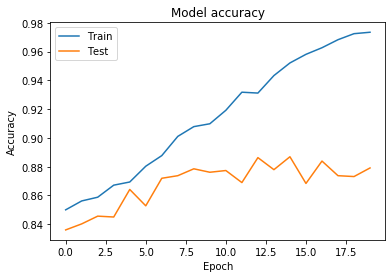

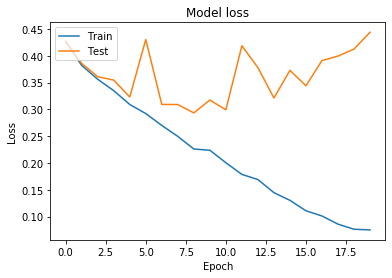

In [9]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(foldername + 'train_gacc.png', dpi=64)
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(foldername + 'train_gloss.png', dpi=64)
plt.show()

file = open('test_data.pkl', 'wb')
test_set = (test_image, test_label)
pickle.dump(test_set, file)
file.close()

file = open('train_data.pkl', 'wb')
train_set = (train_image, train_label)
pickle.dump(train_set, file)
file.close()